In [1]:
# IMPORTS
import sys
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import cv2



In [5]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh*4)

# NORMALIZING THE DYNAMICS
def normalize_dynamics_by_max_dynamic_in_file(dynamics_over_time_all_files):
    for i in range(0, len(dynamics_over_time_all_files)):
        
        max = dynamics_over_time_all_files[i].copy().flat[abs(dynamics_over_time_all_files[i]).argmax()]
        # max = np.max(dynamics_over_time_all_files[i])
        dynamics_over_time_all_files[i] = dynamics_over_time_all_files[i]/max
    return dynamics_over_time_all_files

def read_mask(directory_path, filename):
    image = cv2.imread("{0}/{1}".format(directory_path, filename))
    mask = np.where(image<255)
    return mask

def get_available_masks(directory_path):
    directory = os.fsencode(directory_path)
    masked_files = list()
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.mov'):
            masked_files.append(filename[:-4])
    return masked_files

def analyze_file(filename, mask=None):
    cap = cv2.VideoCapture("../ForAnalyze/{0}".format(filename))
    final_frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)    
    average_dynamics_over_time = np.zeros(int(final_frame_count-1))
    last_average = -1
    fc=0
    ret = True
    while fc< final_frame_count-1 and ret:
        ret, frame = cap.read()
        if last_average >= 0:
            if mask:
                current_avg = np.average(frame[mask])
                average_dynamics_over_time[fc] = current_avg - last_average
                last_average = current_avg
            else:
                current_avg = np.average(frame)
                average_dynamics_over_time[fc] = current_avg - last_average
                last_average = current_avg
        else:
            if mask:
                last_average = np.average(frame[mask])
            else:
                last_average = np.average(frame)
        fc+=1
                
    return filename, average_dynamics_over_time
    
        

In [6]:
masks_directory= "../PlateletsMasks"
directory = os.fsencode("../ForAnalyze")
total_files =""
finished_files = list()
dynamics_over_time_all_files = list()
available_masks = get_available_masks(masks_directory)
# available_masks = None
mask = None
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith('.mp4') or filename.endswith('.avi') or filename.endswith('.mov'):
        try:
            index_in_mask = available_masks.index(filename[:-4])
        except Exception as e:
            index_in_mask = -1            
        if index_in_mask>=0:
            mask = read_mask(masks_directory, filename[:-4]+".jpg")  
            file_processed_name, result = analyze_file(filename, mask)
        else:
            file_processed_name, result = analyze_file(filename, None)
        dynamics_over_time_all_files.append(result)
        finished_files.append(file_processed_name)


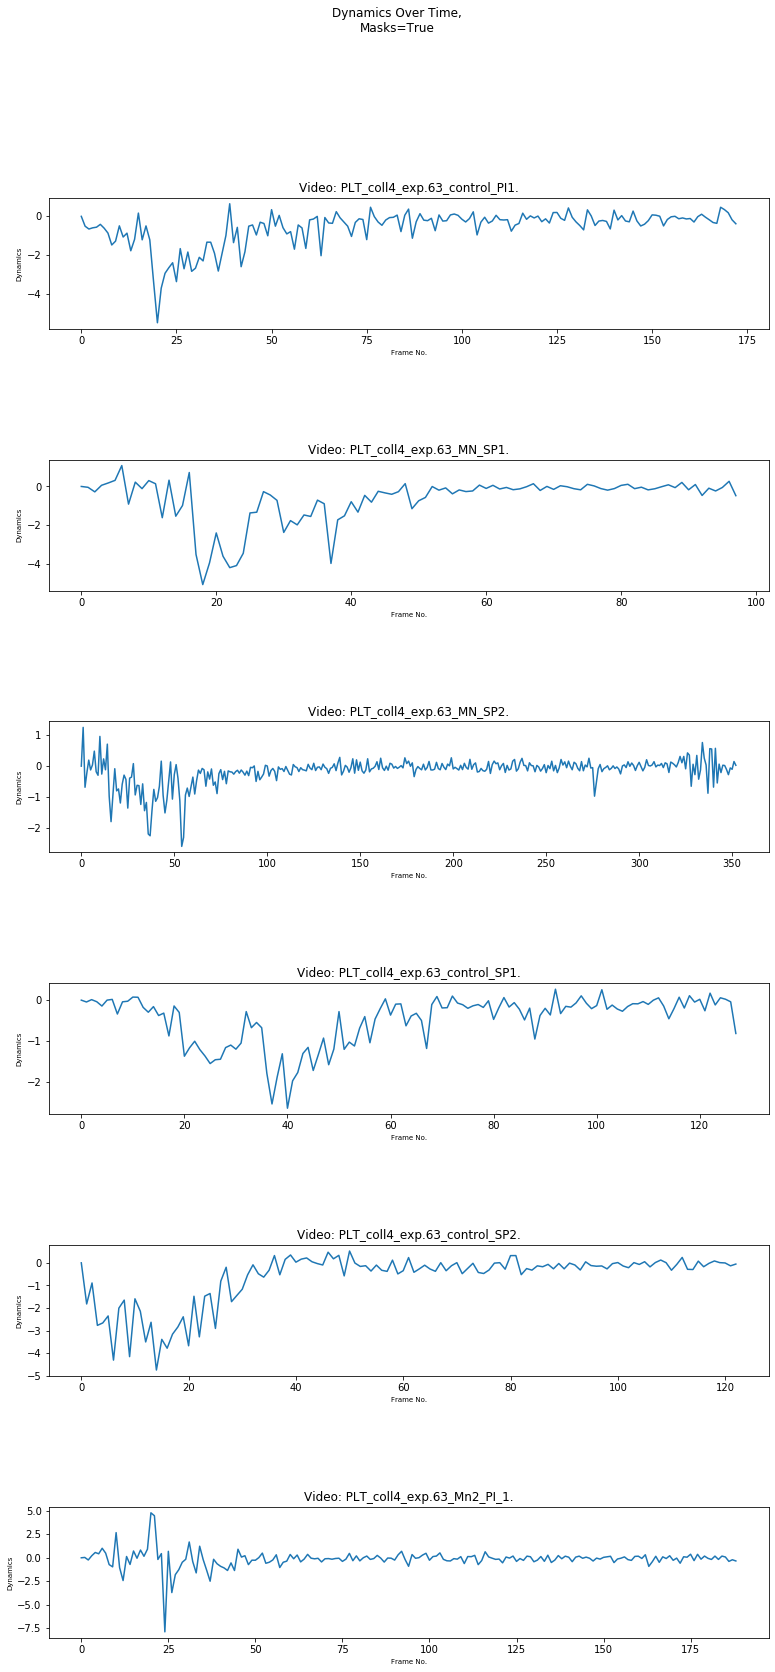

In [8]:
# PLOTTING THE FILES DYNAMICS
# dynamics_over_time_all_files = normalize_dynamics_by_max_dynamic_in_file(dynamics_over_time_all_files)

fig, axs = plt.subplots(len(dynamics_over_time_all_files))
fig.suptitle('Dynamics Over Time,\nMasks={0}'.format(True if mask else False))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
for i in range(0, len(dynamics_over_time_all_files)):
    axs[i].plot(dynamics_over_time_all_files[i])
    set_size(10,5, axs[i])
    axs[i].set_title('Video: {0}'.format(finished_files[i][:-3]))
    # axs[i].set
    axs[i].xaxis.label.set_size(7)
    axs[i].yaxis.label.set_size(7)
    axs[i].set(xlabel="Frame No.", ylabel="Dynamics")
fig.savefig("test.png", dpi=200)


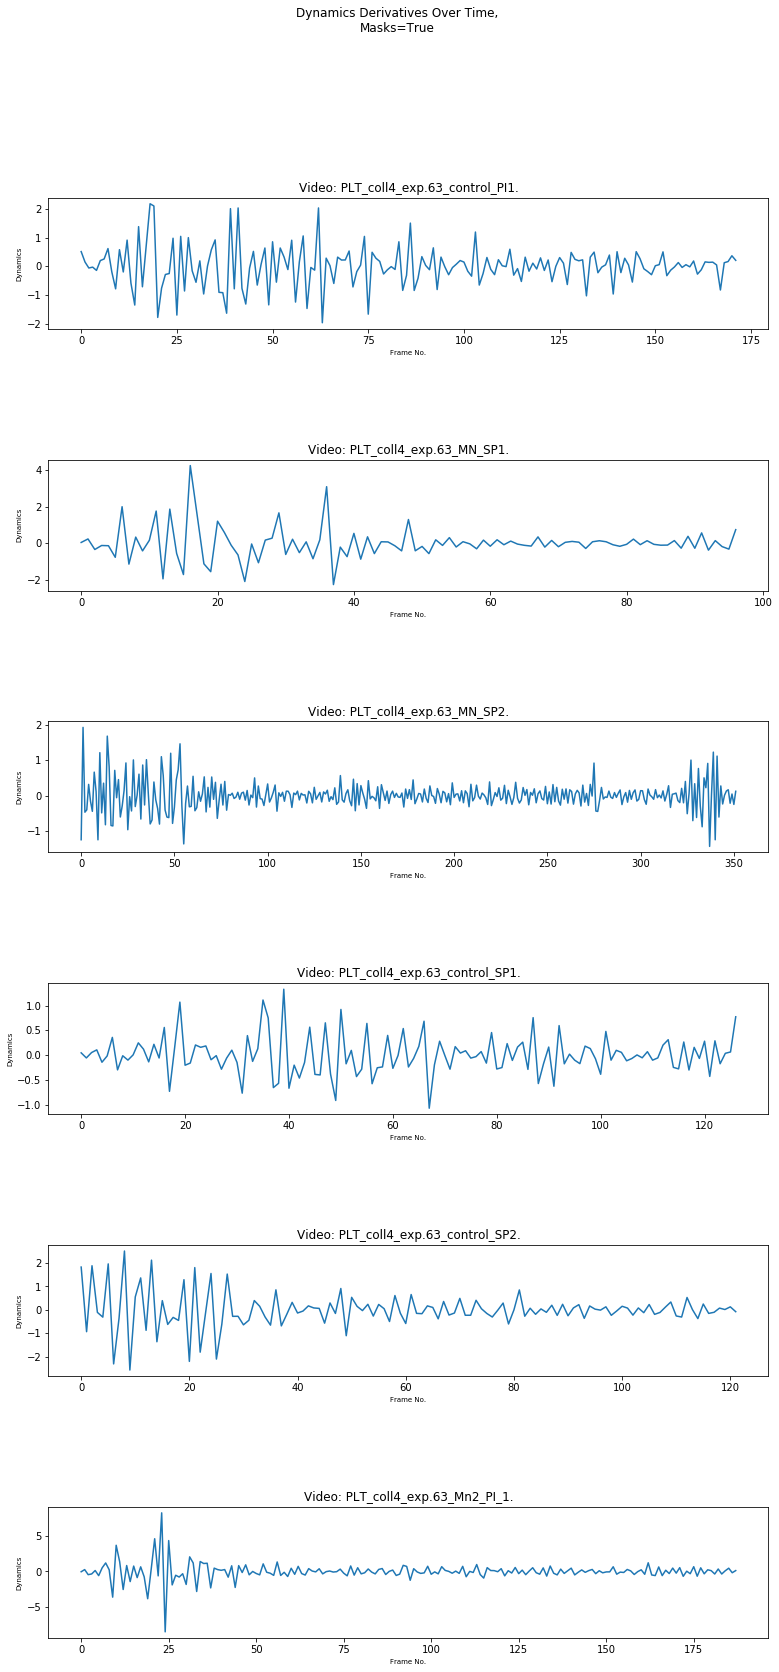

In [9]:
def calc_derivatives(vector):
    derivatives_vector = np.zeros((len(vector)-1))
    for j in range(0,len(vector)-1):
        derivatives_vector[j] = vector[j]-vector[j+1]
    return derivatives_vector

derivatives_of_dynamics_all_files = list()
for i, video_dynamics in enumerate(dynamics_over_time_all_files):
    derivatives_of_dynamics_all_files.append(calc_derivatives(video_dynamics))

fig, axs = plt.subplots(len(derivatives_of_dynamics_all_files))
fig.suptitle('Dynamics Derivatives Over Time,\nMasks={0}'.format(True if mask else False))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
for i in range(0, len(derivatives_of_dynamics_all_files)):
    axs[i].plot(derivatives_of_dynamics_all_files[i])
    set_size(10,5, axs[i])
    axs[i].set_title('Video: {0}'.format(finished_files[i][:-3]))
    # axs[i].set
    axs[i].xaxis.label.set_size(7)
    axs[i].yaxis.label.set_size(7)
    axs[i].set(xlabel="Frame No.", ylabel="Dynamics")
fig.savefig("test.png", dpi=200)

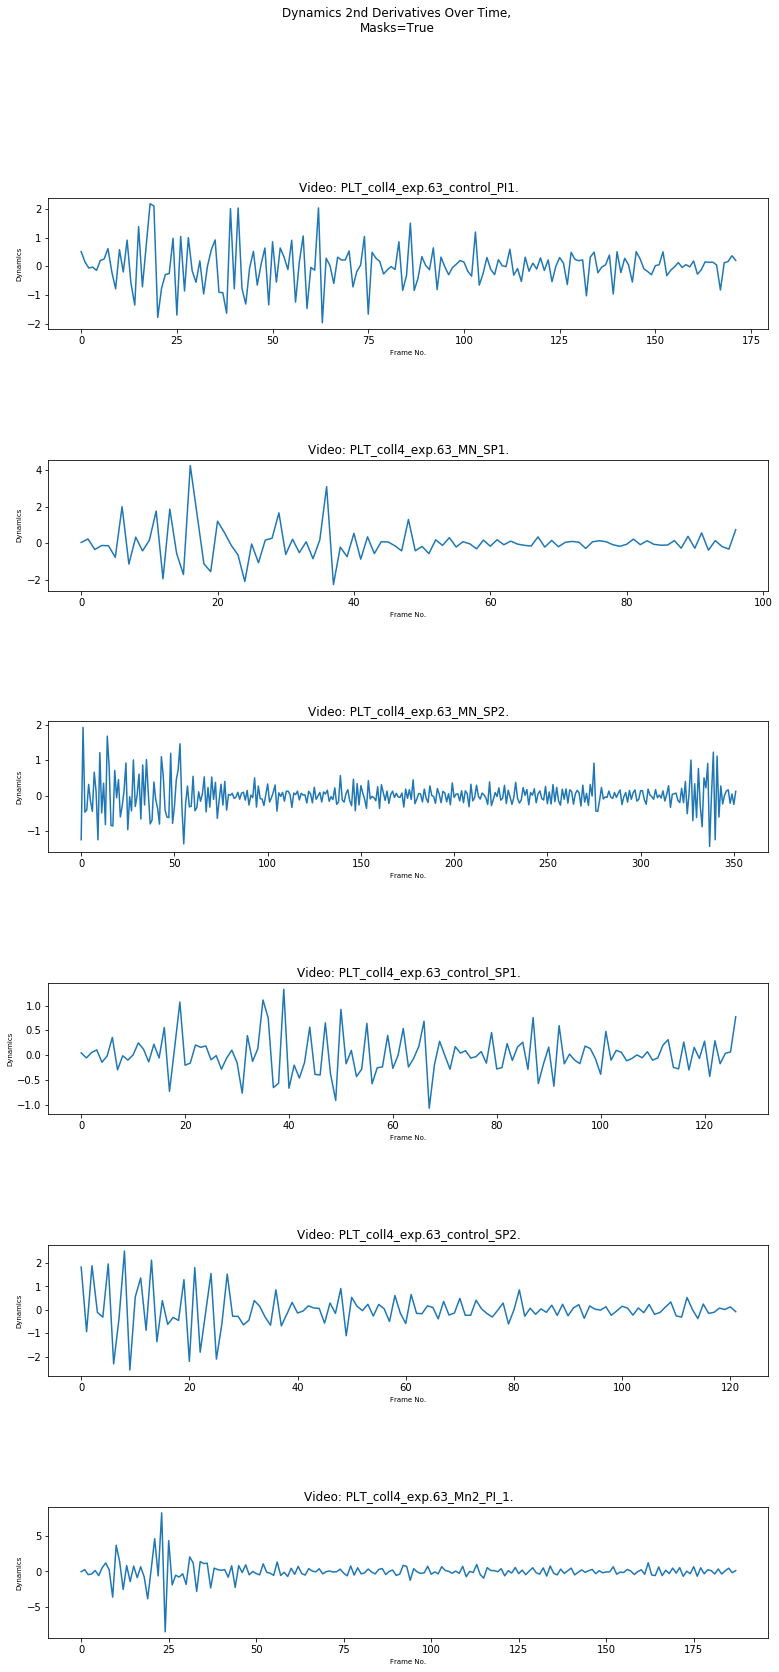

In [10]:
sec_derivatives_of_dynamics_all_files = list()
for i, video_dynamics in enumerate(derivatives_of_dynamics_all_files):
    sec_derivatives_of_dynamics_all_files.append(calc_derivatives(video_dynamics))

fig, axs = plt.subplots(len(sec_derivatives_of_dynamics_all_files))
fig.suptitle('Dynamics 2nd Derivatives Over Time,\nMasks={0}'.format(True if mask else False))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
for i in range(0, len(sec_derivatives_of_dynamics_all_files)):
    axs[i].plot(derivatives_of_dynamics_all_files[i])
    set_size(10,5, axs[i])
    axs[i].set_title('Video: {0}'.format(finished_files[i][:-3]))
    # axs[i].set
    axs[i].xaxis.label.set_size(7)
    axs[i].yaxis.label.set_size(7)
    axs[i].set(xlabel="Frame No.", ylabel="Dynamics")
fig.savefig("test.png", dpi=200)